## Introduction
Rekordbox, a program utilized by DJ's to organize individual songs/tracks (I'll use these terms interchangably) in a database, is rich with metadata. The songs/tracks in most DJ's libraries comes from a wide variety of sources with varying standards of completeness in terms of metadata tagging. As such it represents an unclean dataset that's ripe for data cleaning and exploratory data analysis.

#### Data
Rekordbox data can be exported in XML, which is a plain text format utilized for storing data. After exporting my database in XML Format from within Rekordbox, I converted the XML file to a CSV for easier analysis using <a href='https://www.convertcsv.com/xml-to-csv.htm'>the following website</a>.

#### Results / Insights
For description and further analysis, please refer to the EDA section.

1. Over 50% of my music is between 120 to 132 Beats Per Minute.
2. At least 75% of my tracks have been played 3 times or less and 25% I haven't even played once.

---

# Preliminary EDA
My initial rekordbox file contains 5413 tracks containing 92 features. The majority of these features are utilized for identifying specific time stamp and can be identifed by their beginning with 'POSITION_MARK'. These columns aren't necessary for the analysis, so they will be deleted.

In [172]:
# Hide Cell Inputs
{
    "tags": [
        "hide-input",
    ]
}

# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

df = pd.read_csv('MyRekordboxEDA.csv')
df.info(verbose = False) # Remove verbose to see column names

# Removing the excessive amount of 'Cue Point' Columns, which all occur after the 25th column
df = df.iloc[:,1:26]

# Removing Prefix from Column Names
df.columns = df.columns.str.lstrip("_")

# 'GENRE' FEATURE ENGINEERING...
# Multiple Genres are Listed in the same cell. Splitting them up for easier future analysis.
df[['Genre1','Genre2','Genre3','Genre4','Genre5']] = df['Genre'].str.split(', ', n=4, expand=True)

def MainGenre(row):  
    if row['Genre1'] == 'Techno' or row['Genre1'] == 'Deep Techno' or row['Genre1'] == 'Dub Techno' or row['Genre1'] == 'Industrial Techno' :
        return 'Techno'
    elif row['Genre1'] == 'Drum & Bass' or row['Genre1'] == 'Jungle' or row['Genre1'] == 'Dubstep' or row['Genre1'] == 'Dungeon Dubstep':
        return 'Bass Music'
    elif row['Genre1'] == 'Electro' or row['Genre1'] == 'Breaks' or row['Genre1'] == 'UK Breaks':
        return 'Breaks'
    elif row['Genre1'] == 'House':
        return 'House'
    elif row['Genre1'] == 'Industrial' or row['Genre1'] == 'Acid':
        return 'Industrial/Acid'
    elif row['Genre1'] == 'Tech House' or row['Genre1'] == 'Minimal / Tech House' or row['Genre1'] == 'Minimal':
        return 'Tech House'
    elif row['Genre1'] == 'Deep House':
        return 'Deep House'
    elif row['Genre1'] == 'Left Field' or row['Genre1'] == 'Left Field House' or row['Genre1'] == 'Left Field Techno' or row['Genre1'] == 'Outsider House' or row['Genre1'] == 'Left Field Downtempo':
        return 'Left Field'
    elif row['Genre1'] == 'Downtempo' or row['Genre1'] == 'Chill Out' or row['Genre1'] == 'Dub':
        return 'Downtempo/Dub'
    elif row['Genre1'] == 'Rave House' or row['Genre1'] == 'Rave Techno' or row['Genre1'] == 'Rave Breaks' or row['Genre1'] == 'Rave':
        return 'Rave'
    elif row['Genre1'] == 'Ambient' or row['Genre1'] == 'Beatless' or row['Genre1'] == 'Experimental':
        return 'Ambient/Experimental'
    elif row['Genre1'] == 'Disco' or row['Genre1'] == 'Soul' or row['Genre1'] == 'Funk' or row['Genre1'] == 'Italo Disco' or row['Genre1'] == 'Nu Disco':
        return 'Disco/Funk/Soul'
    elif row['Genre1'] == 'EBM' or row['Genre1'] == 'Post-Punk':
        return 'EBM/Post-Punk'
    return 'Other'

# Using These Two Lines to Decipher What is being classified as Other from the previous function. From here, I can assign appropriate Genre_Main (see next step)
# a = df[df['Genre_Main'] == 'Other']
# a['Genre1'].value_counts()
# To DO... Create a category for Multi-Genre... interested in music that's harder to classify, since find artist is saying something that hasn't been done before

df['Genre_Main'] = df.apply(lambda row: MainGenre(row), axis=1)
# df[df['Genre_Main'] == 'Other']
# df['Genre_Main'].value_counts() # TO DO to Figure 'Other' Out.. there's still a lot of genres that aren't classified correc

# Dropping the 1k songs where Genre = Other
df = df[df['Genre_Main'] != 'Other']


# Effectively Bins Beats Per Minute (BPM) of Individual Tracks. For example, rekordbox might classify a song that's 125 bpm as 125.01 or 125.05 bpm. This makes that song 125 bpm.
df['AverageBpm'] = df['AverageBpm'].astype(int)

print('\nExample Row from Dataset')
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 0 to 5413
Columns: 92 entries, _TrackID to POSITION_MARK/8/_Num
dtypes: float64(60), int64(10), object(22)
memory usage: 3.8+ MB

Example Row from Dataset


,Name,Artist,Composer,Album,Grouping,Genre,Kind,Size,TotalTime,DiscNumber,...,Tonality,Label,Mix,Colour,Genre1,Genre2,Genre3,Genre4,Genre5,Genre_Main
0,Impressions,Zemi17,NaN,Impressions,Yellow,Deep Techno,MP3 File,25152044,627,0,...,6A,NaN,NaN,0xFFFF00,Deep Techno,None,None,None,None,Techno


<B> Utilizing the Describe Method</b>, I uncovered the following particularly useful insights...<br>
- AverageBPM
    - 'Year' has a minimum value of 0, which means that some of my tracks don't have the year categorized.
        - After <i>running 'df[df['Year'] == 0]'</i>, I found that 1,344 songs don't have the year listed.
- PlayCount
    - At least 75% of my tracks have been played 3 times or less and 25% I haven't even played once!
- TotalTime
    - Is listed in seconds. Maybe I should turn into min + sec?
        - Later on something that might be interesting to do is grouping songs by decade and seeing if I can guess the Genre based on the track length and genre.

In [173]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))) #Display Without Scientific Notation

,Size,TotalTime,DiscNumber,TrackNumber,Year,AverageBpm,BitRate,SampleRate,PlayCount,Rating
count,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000
mean,55258703.391150,391.564096,0.094311,3.265740,1579.840708,123.707965,1142.040455,44531.453856,2.704425,130.652845
std,36657514.956020,122.256977,0.319578,8.444015,836.508802,20.625019,680.344509,4432.656527,3.595840,58.798255
min,305338.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44100.000000,0.000000,0.000000
25%,18183095.500000,316.000000,0.000000,1.000000,1994.000000,120.000000,320.000000,44100.000000,0.000000,102.000000
50%,58012036.000000,376.000000,0.000000,2.000000,2012.000000,126.000000,1411.000000,44100.000000,2.000000,153.000000
75%,76932256.000000,448.500000,0.000000,4.000000,2017.000000,132.000000,1411.000000,44100.000000,4.000000,153.000000
max,422234178.000000,1477.000000,3.000000,312.000000,9707.000000,180.000000,9216.000000,192000.000000,34.000000,255.000000


<b>Table of Columns With the Highest % of Missing Values</b>

In [174]:
# Hide Cell Inputs
{
    "tags": [
        "hide-input",
    ]
}

# Creating a Table of Highest % of Missing Values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

# TO DO Round to 3 decimal points and rename column names
missing_value_df = missing_value_df.sort_values('percent_missing', ascending=False) # Remove Head to Show More
missing_value_df.head(12) # Only 12 columns have missing values

,column_name,percent_missing
Genre5,Genre5,99.949431
Genre4,Genre4,99.317320
Mix,Mix,99.089760
Remixer,Remixer,97.446271
Composer,Composer,95.372946
Genre3,Genre3,91.833123
Label,Label,80.834387
Comments,Comments,72.465234
Genre2,Genre2,63.388116
Colour,Colour,17.243995


# EDA
After elementary data cleaning, I conducted univariate analysis and when appropriate did further feature engineering.

### 1. Grouping
The column for 'Grouping' is used in Rekordbox to classify a color to an individual track. In contrast to a feature such as Artist or Song Title which has a common definition, 'Grouping' is up to the discrection of the Rekordbox user what they'd use it for. There have been times where I've grown bored of hearing a specific track, so I'll delete it and later regret it. Since hard drive limitations aren't really an issue, I've become a bit of a music hoarder. I use Grouping (AKA color) in Rekordbox as follows...
- <font color='Green'>Green</font> = These are my gold medal tracks. I LOVE this track and I'd love to play it out.
- <font color='Aqua'>Aqua</font> = Think of this as a Silver Medalist. I really like this track and I'll likely play it at a gig if the time is the right
- <font color='Yellow'>Yellow</font> = I have no plans of deleting this track anytime soon, it's just I'm either bored of playing it or might only play it since it blends well with something in the Aqua or Green Categories
- <font color='Pink'>Pink</font> = Need to Classify still
- <font color='Orange'>Orange</font> and <font color='Red'>Red</font> = I'll probably delete these tracks, but haven't quite yet. Sometimes I'll classify tracks like this that either a remaster is available or a better quality version, but I haven't gotten around to buying it.
- <font color='Purple'>Purple</font> and <font color='Blue'>Blue</font> = These exist, but not quite sure what they represent yet... this is why having a data dictionary is important...

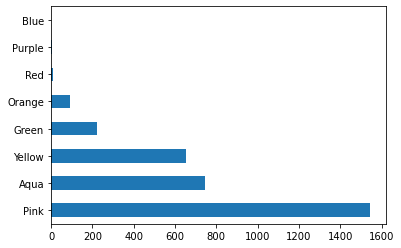

In [175]:
df['Grouping'].value_counts().plot(kind='barh') # Convert this to Tracks I'm Bored of Playing

# Creating a dictionary for colors to make more intuitive visualizations (example: coffee is brown, water is blue, etc.)
color_discrete_map= {'Pink': 'pink',
                     'Aqua': 'aqua',
                     'Yellow': 'yellow',
                     'Green': 'green',
                     'orange': 'orange',
                     'Water':'blue'}             

### 2. Kind
Kind identifies the file type. While the majority of my tracks are lossless, I should convert the M4A + ALAC + Unknown Format tracks to a different format so they are more likely to play on all the different types of equipment I utilize.

<AxesSubplot:>

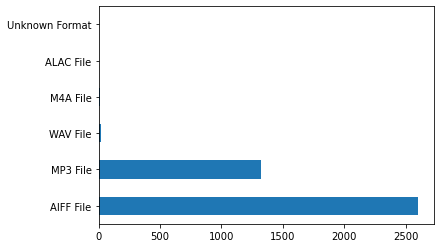

In [176]:
df['Kind'].value_counts().plot(kind='barh')

### 3. Tonality
In Rekordbox, tonality is displayed as a series of number + letter combos in my library.

![](2022-09-20-11-49-43.png)
<br>Color-Key Code

c:\Users\nickb\Anaconda3\lib\site-packages\pandas\core\missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


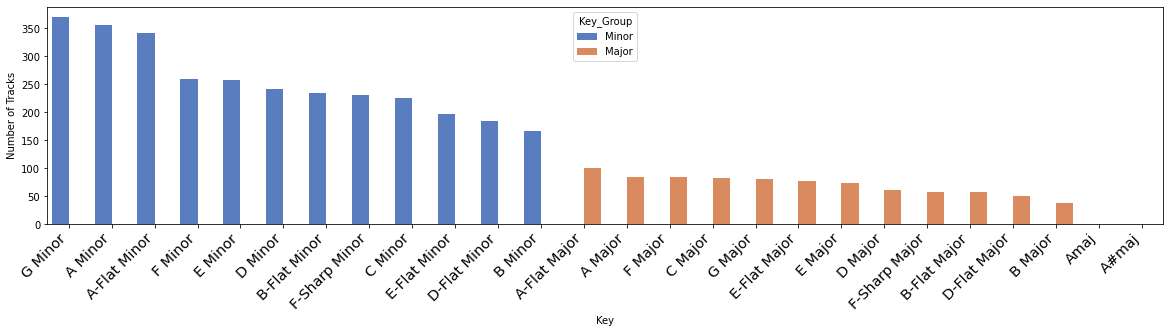

In [177]:
# converting dtypes using astype
df['Tonality']= df['Tonality'].astype('string')

# Converting Values from Number/Letter-Based to Music Scale Name
df.replace({'Tonality':{'8A' : 'A Minor',
                        '6A' : 'G Minor',
                        '1A' : 'A-Flat Minor',
                        '9A' : 'E Minor',
                        '4A' : 'F Minor',
                        '7A' : 'D Minor',
                        '11A' : 'F-Sharp Minor',
                        '3A' : 'B-Flat Minor',
                        '5A' : 'C Minor',
                        '2A' : 'E-Flat Minor',
                        '12A' : 'D-Flat Minor',
                        '10A' : 'B Minor',
                        '4B' : 'A-Flat Major',
                        '7B' : 'F Major',
                        '11B' : 'A Major',
                        '9B' : 'G Major',
                        '8B' : 'C Major',
                        '5B' : 'E-Flat Major',
                        '12B' : 'E Major',
                        '10B' : 'D Major',
                        '6B' : 'B-Flat Major',
                        '2B' : 'F-Sharp Major',
                        '3B' : 'D-Flat Major',
                        '1B' : 'B Major',}},
                        inplace=True)
                        
# Creating New Column for Minor or Major Key
df['Key_Group'] = df['Tonality'].str.split(' ').str[1]

# Replacing A Major Values
df['Tonality'].replace('Amaj', 'A Major', inplace=True)
df['Tonality'].replace('A#maj', 'A Major', inplace=True)

# Dropping values that contain the STRING value 'nan'
df = df[df['Tonality'] != 'nan']


# CREATING A PLOT
plt.figure(figsize=(20,4))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
    )

ax = sns.countplot(
              x = 'Tonality',
              data = df,
              order = df['Tonality'].value_counts().index,
              palette='muted',
              hue='Key_Group'
              )

ax.set(xlabel='Key', ylabel='Number of Tracks')

plt.show()

### 4. Record Label
After running 'df['Label'].notna().value_counts()', I saw that only 977 of my tracks have a label listed. I built the following bar chart utilizing just the tracks that had their record label listed.

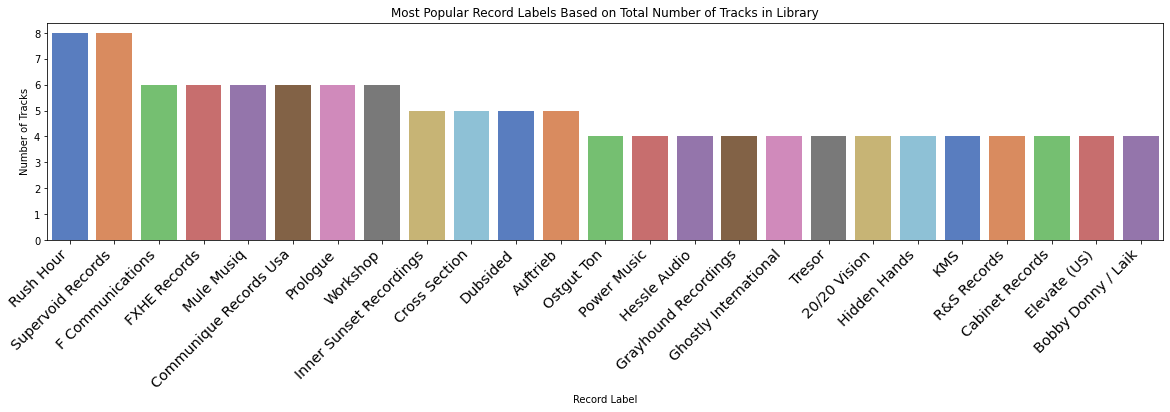

In [178]:
df['Label'] = df['Label'].astype('string')

# CREATING A PLOT
plt.figure(figsize=(20,4))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
    )

#TO DO Make Color = Primary Genre
ax = sns.countplot(
              x = 'Label',
              data = df,
              order = pd.value_counts(df['Label']).iloc[:25].index,
              palette='muted'
              #hue='Key_Group'
              )

ax.set(xlabel='Record Label',
ylabel='Number of Tracks',
title='Most Popular Record Labels Based on Total Number of Tracks in Library')

plt.show()

# TO DO's...
# Maybe later I can merge databases and get label tags from Discogs?

### 5. Artist

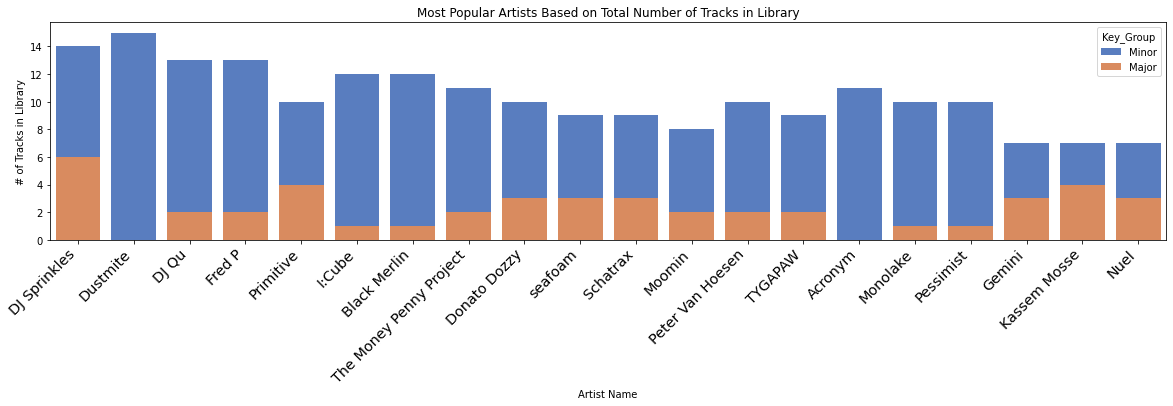

In [179]:
# Most Popular Artists Based on Tracks in Library
plt.figure(figsize=(20,4))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
    )

ax = sns.countplot(
              x = 'Artist',
              data = df,
              order= pd.value_counts(df['Artist']).iloc[:20].index,
              palette='muted',
              hue='Key_Group',
              dodge=False # For Stacking
              )

ax.set(xlabel='Artist Name',
       ylabel='# of Tracks in Library',
       title='Most Popular Artists Based on Total Number of Tracks in Library')

plt.show()

### 6. Year
This signifies the year a track was released. There are over 1.3k tracks that have the year classified as zero.

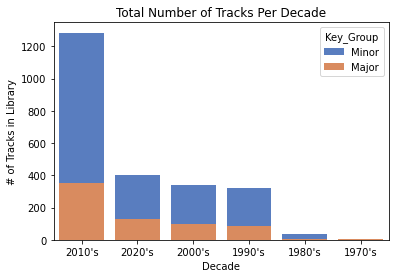

In [180]:
# Based on Average BPM, Genre, Length... calculate Year
year_zero = df[df['Year'] < 1970]
# year_zero.head()

# Removing Tracks released before 1970, which is incorrect data based upon personal knowledge of library
df = df[df['Year'] > 1970]

# ... And After 2022, since it's currently that year so anything after this year is incorrect.
df = df[df['Year'] <= 2022]

# CREATING A DECADES COLUMN...
# Creating the bins for each decade
conditions = [
    (df['Year'] < 1980),
    (df['Year'] >= 1980) & (df['Year'] < 1990),
    (df['Year'] >= 1990) & (df['Year'] < 2000),
    (df['Year'] >= 2000) & (df['Year'] < 2010),
    (df['Year'] >= 2010) & (df['Year'] < 2020),
    (df['Year'] >= 2020)
]

# Creating the names for each decade
values = ['1970\'s','1980\'s','1990\'s','2000\'s','2010\'s','2020\'s']

df['Decade'] = np.select(conditions, values)

ax = sns.countplot(
              x = 'Decade',
              data = df,
              order= pd.value_counts(df['Decade']).iloc[:20].index,
              palette='muted',
              hue='Key_Group',
              dodge=False # For Stacking
              )

ax.set(xlabel='Decade',
# TO DO Change Minor/Major Colors & Edit Key Group Name
ylabel='# of Tracks in Library',
title="Total Number of Tracks Per Decade")

plt.show()

<b>Year/Month Added</b><br>
This is when I added the music to my library. It could be interesting to see if there are any seasonal trends or how my tastes have shifted over time. <br>

<i>Identify Seasonality</i>

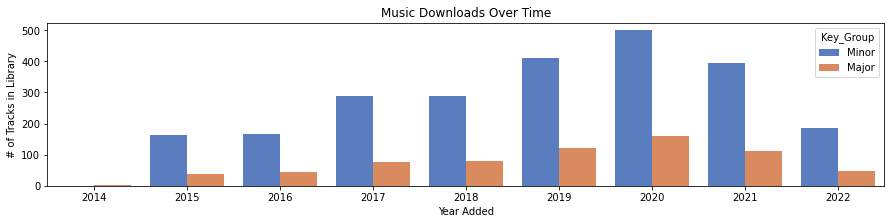

In [181]:
# Converting Dates and Adding Year + Month Added Columns (check seasonality)
df['DateAdded'] = pd.to_datetime(df['DateAdded'])
df['YearAdded'] = df['DateAdded'].dt.year
df['MonthAdded'] = df['DateAdded'].dt.month
df['month_year_added'] = pd.to_datetime(df['DateAdded']).dt.to_period('M')

# TO DO's...
# LABEL AXES, TITLE, ABBREVIATED MONTH NAME (?), 
# df['MonthAdded'].value_counts().plot(kind='barh')

df_noPink = df[df['Grouping'] != 'Pink']

# TO DO: COLOR NAMES ARE INACCURATE SO NOT DISPLAYING FOR NOW
# plt.figure(figsize=(15, 3))
# ax = sns.countplot(
#               x = 'Genre_Main',
#               data = df_noPink,
#             #   palette='muted',
#               hue='Grouping',
#               # dodge=False # For Stacking
#               )

# ax.set(xlabel='Genre', ylabel='# of Tracks in Library')
# plt.show()

# Bar Chart Based on Year Added
plt.figure(figsize=(15, 3))
ax = sns.countplot(
              x = 'YearAdded',
              data = df,
              palette='muted',
              hue='Key_Group',
              # dodge=False # For Stacking
              )

ax.set(xlabel='Year Added',
       ylabel='# of Tracks in Library',
       title='Music Downloads Over Time')
plt.show()

# TO DO: have this be a lineplot that's month + genre based in plotly

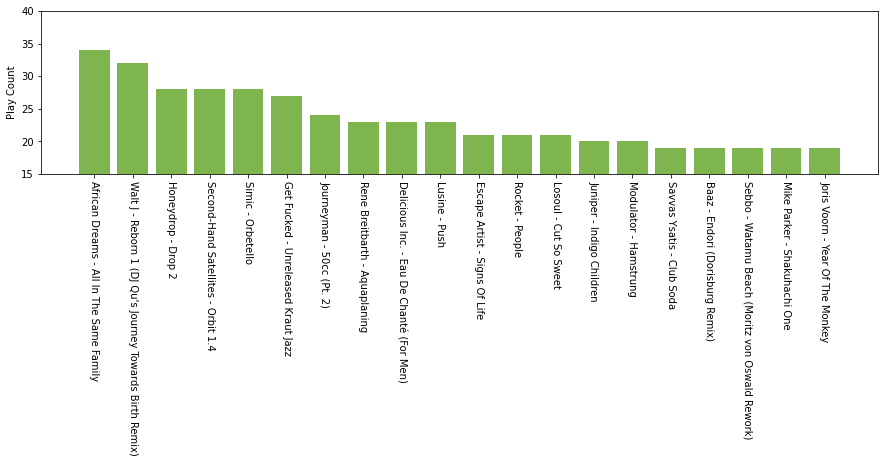

In [182]:
# Creating a List of Top 20 Tracks
Top20Tracks = df.nlargest(n=20, columns=['PlayCount'])
Top20Tracks['ArtistAndTrack'] = Top20Tracks['Artist'] + " - " + Top20Tracks['Name']
Top20Tracks['ArtistAndTrack']

# Plotting Top 20 Tracks
plt.figure(figsize=(15, 3))
plt.bar(Top20Tracks['ArtistAndTrack'],Top20Tracks["PlayCount"], color='#7eb54e')
plt.xticks(rotation=270)
plt.ylabel("Play Count")
plt.ylim([15, 40])
plt.show()

In [183]:
DateAddedGroupBy = df.groupby(['DateAdded']).count()
YearMonthGroup = df.groupby(['YearAdded', 'MonthAdded'])
YearMonthGroup['PlayCount'].sum()

YearAdded  MonthAdded
2014       10             5
2015       1             68
           3             29
           4             46
           5             84
                         ..
2022       3              4
           4              5
           5              2
           6             27
           7             24
Name: PlayCount, Length: 86, dtype: int64

<AxesSubplot:>

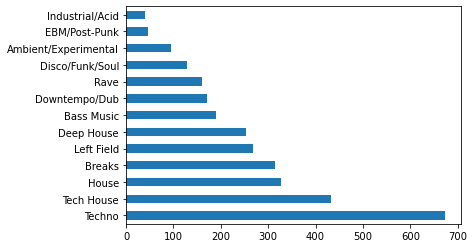

In [184]:
df['Genre_Main'].value_counts().head(20).plot(kind='barh')

In [207]:
# Creating a Count Bar Chart in Plotly
# https://stackoverflow.com/questions/66652742/plot-the-count-of-a-pandas-df-column-using-plotly
new_df = df['Year'].value_counts().rename_axis('Year').reset_index(name='counts')

fig = px.bar(new_df,
             x="Year",
             y="counts",
             #color="counts", # Scrapping From This One But Use in Future
             title="Rekordbox Library Based on a Track's Release Year",
labels={
                     "Year": "Year Track Released",
                     "counts": "Total Number of Tracks"
                 })
fig.show()

In [186]:
# # create a dictionary | key = old name | value = new name
dict = {'AverageBpm': 'BPM',
        'Album': 'Release Name',
        'Name': 'Track Title'}
 
# # call rename () method
df.rename(columns=dict,
          inplace=True)

# Columns to Drop
df.drop(['Size','BitRate','Composer', 'DiscNumber','SampleRate','Comments','Rating','Location','Remixer','Mix','Colour'], axis=1, inplace=True)

# Future Ideas for this Project
-  Set up visualizations + statistics automatically based on user submitted Rekordbox data.
- Setup Data Dictionary File

In [187]:
# Get Discogs API Connected

# pd.df.merge(data_styles, how='inner', on=None, left_on=['A_c1','c2'], right_on=['A_c1','c2'], left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)[source]
# df.to_excel("Rekordbox - Excel.xlsx")


| Field  | Definition | Usage Comments | Prior Field Name |
| ------------- | ------------- | ------------- |------------- |
| Track Title  | Title of the Track  |  | Name |
| Artist  | Artist of the Track  |    |  |
| Release Name  | Name of the Release the Track From  |    | Album |
| PlayCount  | How Many Times I've Played a Track  |    | |
| AverageBpm  | Beats Per Minute  |    | |
| Year  | The Year a Track was Released  |    | |